# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


## Loading the test image and preprocessing

In [3]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

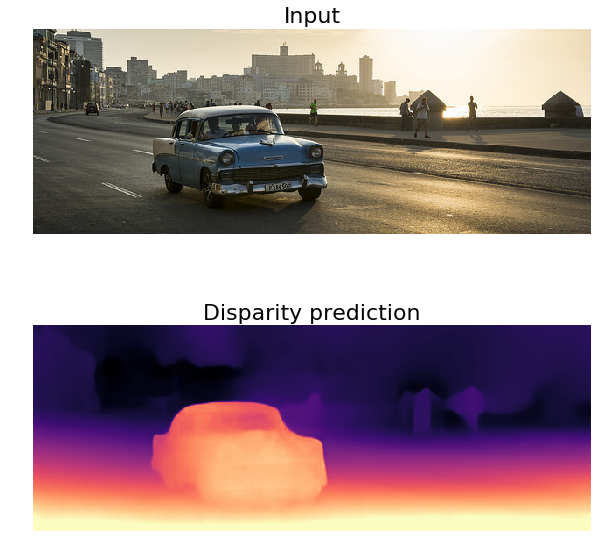

In [5]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [7]:
disp.min()

tensor(0.0237)

In [8]:
disp.max()

tensor(0.5592)

In [17]:
list(depth_decoder.parameters())

[Parameter containing:
 tensor([[[[ 3.5606e-02,  4.0366e-02,  3.5683e-02],
           [ 1.5289e-03,  1.6806e-02, -1.5120e-02],
           [ 2.6241e-02, -9.9670e-03, -7.3811e-02]],
 
          [[-3.3656e-02, -1.6495e-02,  7.5062e-03],
           [-9.8233e-03, -1.3191e-02,  3.6103e-03],
           [-2.4633e-03,  1.7525e-02,  2.0912e-02]],
 
          [[-1.4521e-03, -2.7445e-02,  1.1135e-02],
           [-2.1886e-02, -3.5387e-02,  2.3923e-02],
           [ 1.4758e-02,  4.6150e-02,  4.6079e-02]],
 
          ...,
 
          [[-1.3637e-02, -2.3045e-02, -1.5424e-02],
           [ 1.8734e-02, -1.7210e-02, -1.0711e-02],
           [ 1.8268e-02,  1.0866e-02, -4.4876e-03]],
 
          [[ 4.4467e-02, -6.4437e-03, -4.6724e-02],
           [-6.8469e-03,  1.8083e-02, -3.1767e-02],
           [ 3.0290e-02,  2.3586e-02, -2.1292e-02]],
 
          [[-2.5984e-03, -1.5878e-02, -1.2948e-02],
           [-2.7765e-03,  1.6153e-02, -2.2194e-02],
           [-4.9113e-03, -1.6775e-03,  2.7616e-03]]],
 
 
   